<a href="https://colab.research.google.com/github/bforoura/GenAI/blob/main/Module7/bach_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎶 Music Generation with Transformers

In this notebook, we'll walk through the steps required to train your own Transformer model to generate music in the style of the Bach cello suites

In [ ]:
!apt-get install musescore
!apt-get install music21
!apt-get install fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  desktop-file-utils fonts-freefont-ttf libportaudio2 libportmidi0 libqt5help5 libqt5printsupport5
  libqt5qml5 libqt5qmlmodels5 libqt5qmlworkerscript5 libqt5quick5 libqt5sql5 libqt5sql5-sqlite
  libqt5xml5 libqt5xmlpatterns5 musescore-common musescore-general-soundfont-small
  qml-module-qt-labs-folderlistmodel qml-module-qt-labs-settings qml-module-qtgraphicaleffects
  qml-module-qtqml qml-module-qtqml-models2 qml-module-qtquick-controls qml-module-qtquick-dialogs
  qml-module-qtquick-layouts qml-module-qtquick-privatewidgets qml-module-qtquick-window2
  qml-module-qtquick2
Suggested packages:
  qt5-qmltooling-plugins pulseaudio-utils
The following NEW packages will be installed:
  desktop-file-utils fonts-freefont-ttf libportaudio2 libportmidi0 libqt5help5 libqt5printsupport5
  libqt5qml5 libqt5qmlmodels5 libqt5qmlworkerscript5 libqt5q

In [ ]:
import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

from transformer_utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)

## 0. Parameters <a name="parameters"></a>

In [ ]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "/content/data/"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 5000
BATCH_SIZE = 256

GENERATE_LEN = 50

## 1. Prepare the Data

In [ ]:
# Load the data
file_list = glob.glob("/content/data/*.mid")
print(f"Found {len(file_list)} midi files")

Found 36 midi files


In [ ]:
parser = music21.converter

In [ ]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

In [ ]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x7810f0db60b0>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark allegro moderato Quarter=130>
    {0.0} <music21.key.Key of D major>
    {0.0} <music21.meter.TimeSignature 12/8>
    {0.0} <music21.chord.Chord D3>
    {0.5} <music21.chord.Chord D3>
    {1.0} <music21.chord.Chord D3>
    {1.5} <music21.chord.Chord D3>
    {2.0} <music21.chord.Chord D3>
    {2.5} <music21.chord.Chord F#3>
    {3.0} <music21.chord.Chord D3>
    {3.5} <music21.chord.Chord D3>
    {4.0} <music21.chord.Chord A3>
    {4.5} <music21.chord.Chord D3>
    {5.0} <music21.chord.Chord D3>
    {5.5} <music21.chord.Chord D4>
{6.0} <music21.stream.Measure 2 offset=6.0>
    {0.0} <music21.chord.Chord D3>
    {0.5} <music21.chord.Chord D3>
    {1.0} <music21.chord.Chord D3>
    {1.5} <musi

In [ ]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()

1 Parsing /content/data/cs2-4sar.mid


<ipython-input-43-04172d0f16ff>:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


337 notes parsed
2 Parsing /content/data/cs6-1pre.mid
1679 notes parsed
3 Parsing /content/data/cs2-6gig.mid
2414 notes parsed
4 Parsing /content/data/cs6-2all.mid
3099 notes parsed
5 Parsing /content/data/cs5-6gig.mid
3548 notes parsed
6 Parsing /content/data/cs6-3cou.mid
4834 notes parsed
7 Parsing /content/data/cs5-2all.mid
5526 notes parsed
8 Parsing /content/data/cs4-3cou.mid
6448 notes parsed
9 Parsing /content/data/cs1-4sar.mid
6711 notes parsed
10 Parsing /content/data/cs4-2all.mid
7766 notes parsed
11 Parsing /content/data/cs5-3cou.mid
8196 notes parsed
12 Parsing /content/data/cs1-1pre.mid
8854 notes parsed
13 Parsing /content/data/cs1-2all.mid
9775 notes parsed
14 Parsing /content/data/cs1-3cou.mid
10595 notes parsed
15 Parsing /content/data/cs4-4sar.mid
10915 notes parsed
16 Parsing /content/data/cs2-2all.mid
11608 notes parsed
17 Parsing /content/data/cs5-1pre.mid
12917 notes parsed
18 Parsing /content/data/cs3-6gig.mid
13878 notes parsed
19 Parsing /content/data/cs3-1pre.

In [ ]:
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 B4 E4 A4 G4 E4 F#4 G4 E4 F#4 G4 E4 A4 B4 E4 A4 G4 E4 F#4 G4 E4 B4 F#4 E4 A4 G4 E4 B4 F#4 E4 A4 G4 E4 E4 F#4 E4 E-4 E4 E4 G4 F#4 E4 E-4 E4 E4 G4 D4 E4 F#4 C#4 E4 E4 ...

Duration string
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...


## 2. Tokenize the data <a name="tokenize"></a>

In [ ]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

In [ ]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
        28         3
        15         3
        23         3
        22         3
        15         3
        20         3
        22         3
        15         3
        20         3
        22         3
        15         3


In [ ]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 59
0: 
1: [UNK]
2: G3
3: A3
4: D3
5: F3
6: C4
7: D4
8: E3
9: B3

DURATIONS_VOCAB: length = 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 0.0


## 3. Create the Training Set <a name="create"></a>

In [ ]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [ ]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 5,  2, 10, ...,  7,  6, 11],
       [ 2, 10, 18, ...,  6, 11,  3],
       [10, 18, 13, ..., 11,  3,  2],
       ...,
       [ 4,  6,  9, ..., 10, 14,  5],
       [ 6,  9, 24, ..., 14,  5,  2],
       [ 9, 24,  2, ...,  5,  2, 13]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 2, 10, 18, ...,  6, 11,  3],
       [10, 18, 13, ..., 11,  3,  2],
       [18, 13, 14, ...,  3,  2,  3],
       ...,
       [ 6,  9, 24, ..., 14,  5,  2],
       [ 9, 24,  2, ...,  5,  2, 13],
       [24,  2, 14, ...,  2, 13, 10]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,

## 5. Create the causal attention mask function <a name="causal"></a>

In [ ]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## 6. Create a Transformer Block layer <a name="transformer"></a>

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

## 7. Create the Token and Position Embedding <a name="embedder"></a>

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

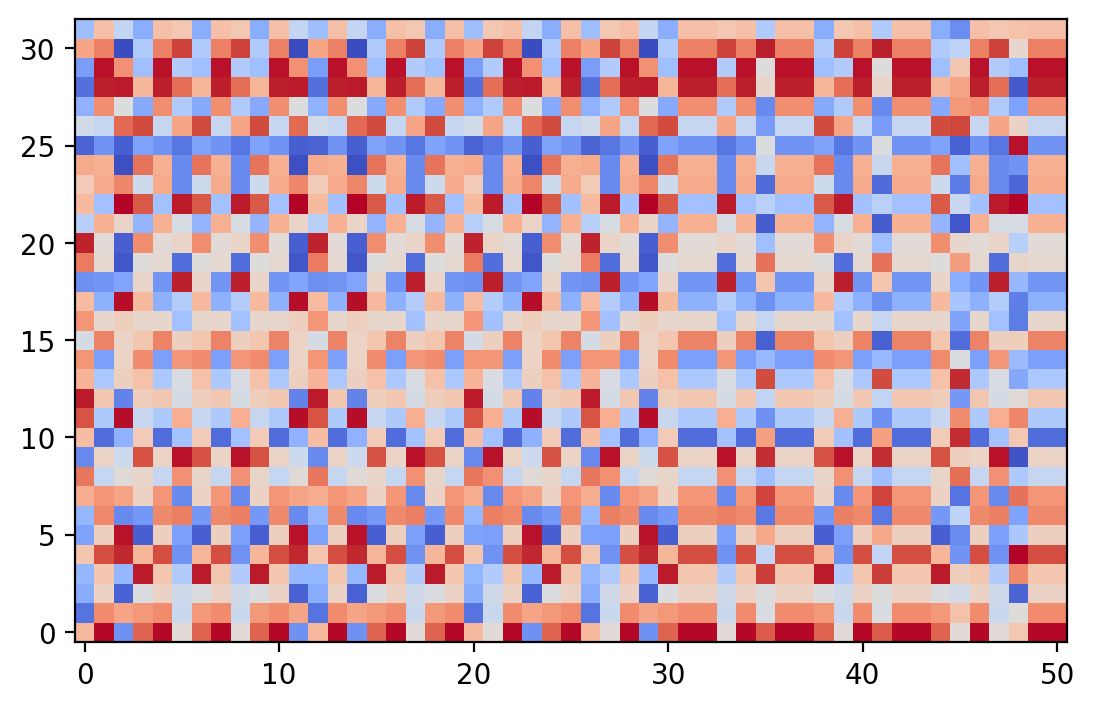

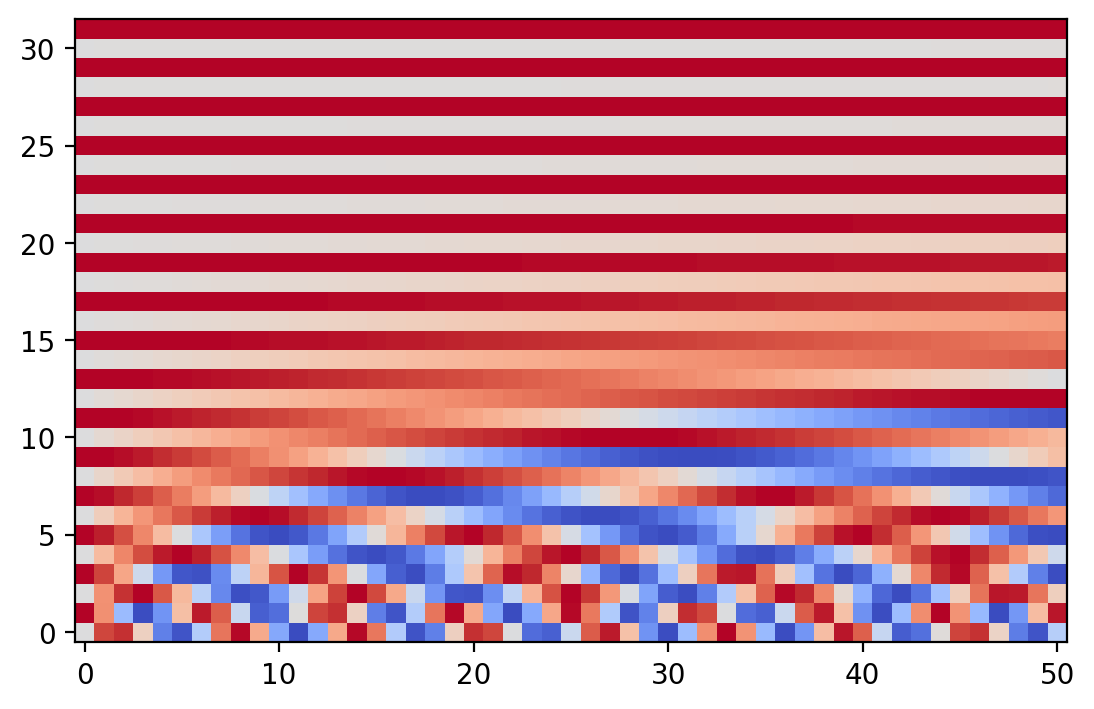

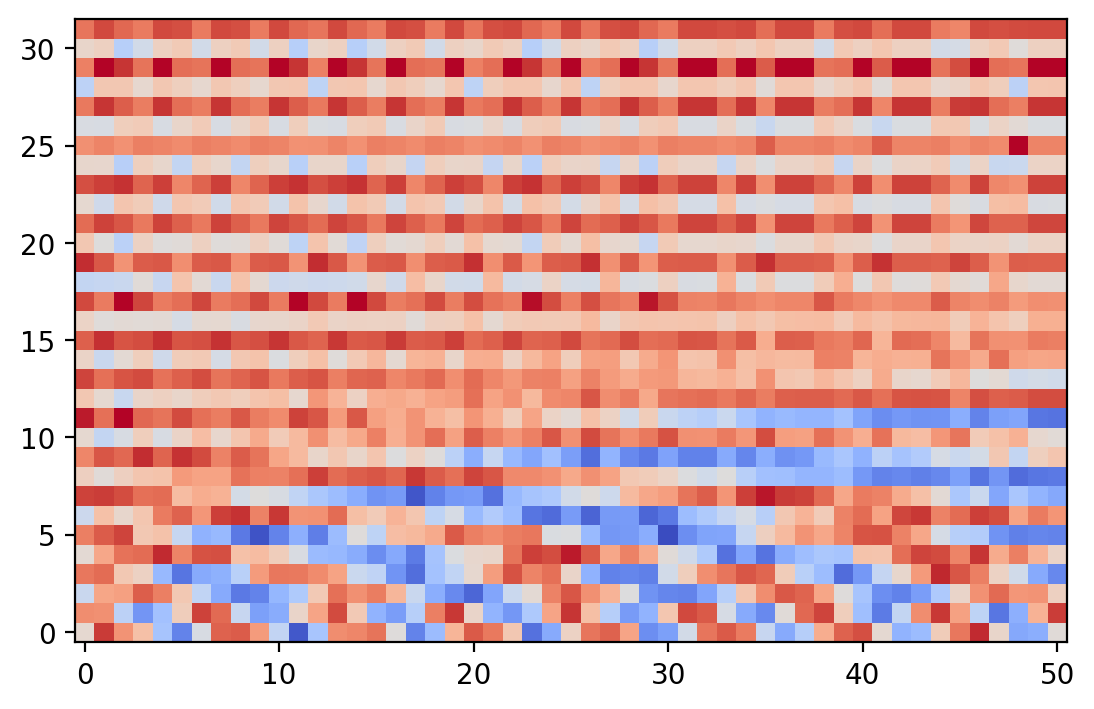

In [ ]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

## 8. Build the Transformer model <a name="transformer_decoder"></a>

In [ ]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 token_and_position_embeddi  (None, None, 128)            7552      ['input_3[0][0]']             
 ng_4 (TokenAndPositionEmbe                                                                       
 dding)                                                                                           
                                                                                            

## 9. Train the Transformer <a name="train"></a>

In [ ]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        #midi_stream.show()
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "/content/output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [ ]:

# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

In [ ]:
model.fit(
    ds,
    epochs=100,
    callbacks=[
        music_generator,
    ],
)

Epoch 1/100
107/107 [==============================] - ETA: 0s - loss: 2.9069 - note_outputs_loss: 2.3450 - duration_outputs_loss: 0.5619

[['START', '4/4TS', 'rest'], ['0.0', '0.0', '2.5']]
107/107 [==============================] - 56s 522ms/step - loss: 2.9069 - note_outputs_loss: 2.3450 - duration_outputs_loss: 0.5619
Epoch 2/100
107/107 [==============================] - 57s 530ms/step - loss: 2.8903 - note_outputs_loss: 2.3335 - duration_outputs_loss: 0.5569
Epoch 3/100
107/107 [==============================] - 64s 598ms/step - loss: 2.8584 - note_outputs_loss: 2.3086 - duration_outputs_loss: 0.5497
Epoch 4/100
107/107 [==============================] - 56s 528ms/step - loss: 2.8572 - note_outputs_loss: 2.3031 - duration_outputs_loss: 0.5541
Epoch 5/100
107/107 [==============================] - 56s 521ms/step - loss: 2.8309 - note_outputs_loss: 2.2773 - duration_outputs_loss: 0.5535
Epoch 6/100
107/107 [==============================] - 56s 527ms/step - loss: 2.8094 - note_outputs_loss: 2.2600 - duration_outputs_loss: 0.5495
Epoch 7/100
107/107 [==============================] - 64s 594ms/step - loss: 2.7991 - not

In [ ]:
# Save the final model
model.save("/content/model")

# 3. Generate music using the Transformer

In [ ]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.5
)
midi_stream = info[-1]["midi"].chordify()
#midi_stream.show()

## Write music to MIDI file

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "/content/transformer_output",
        "output-" + timestr + ".mid",
    ),
)

'/content/transformer_output/output-20240831-221245.mid'

## Note probabilities

In [ ]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

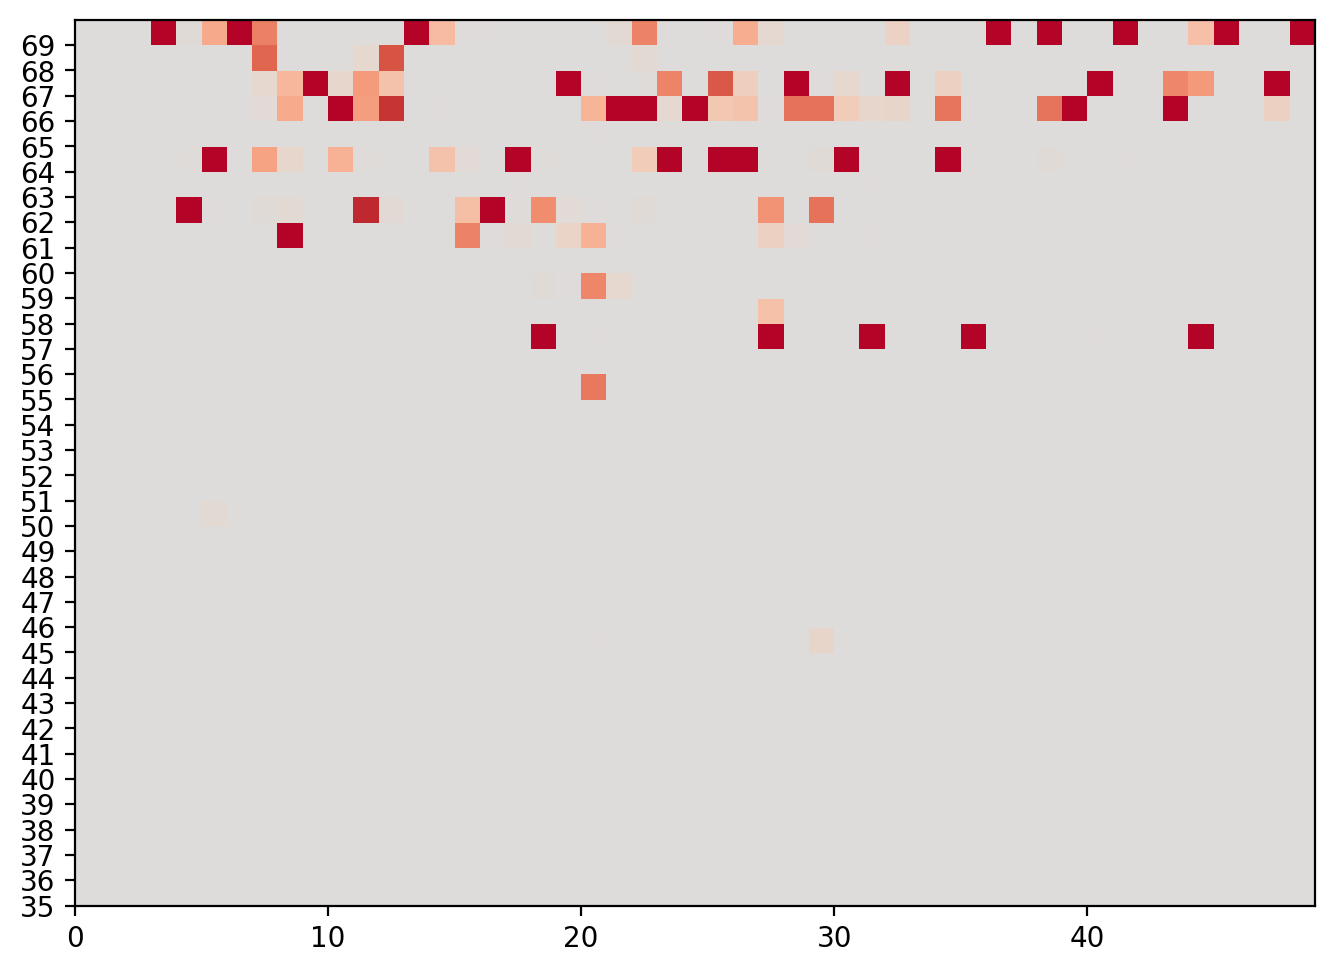

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

## Attention Plot

In [ ]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [ ]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

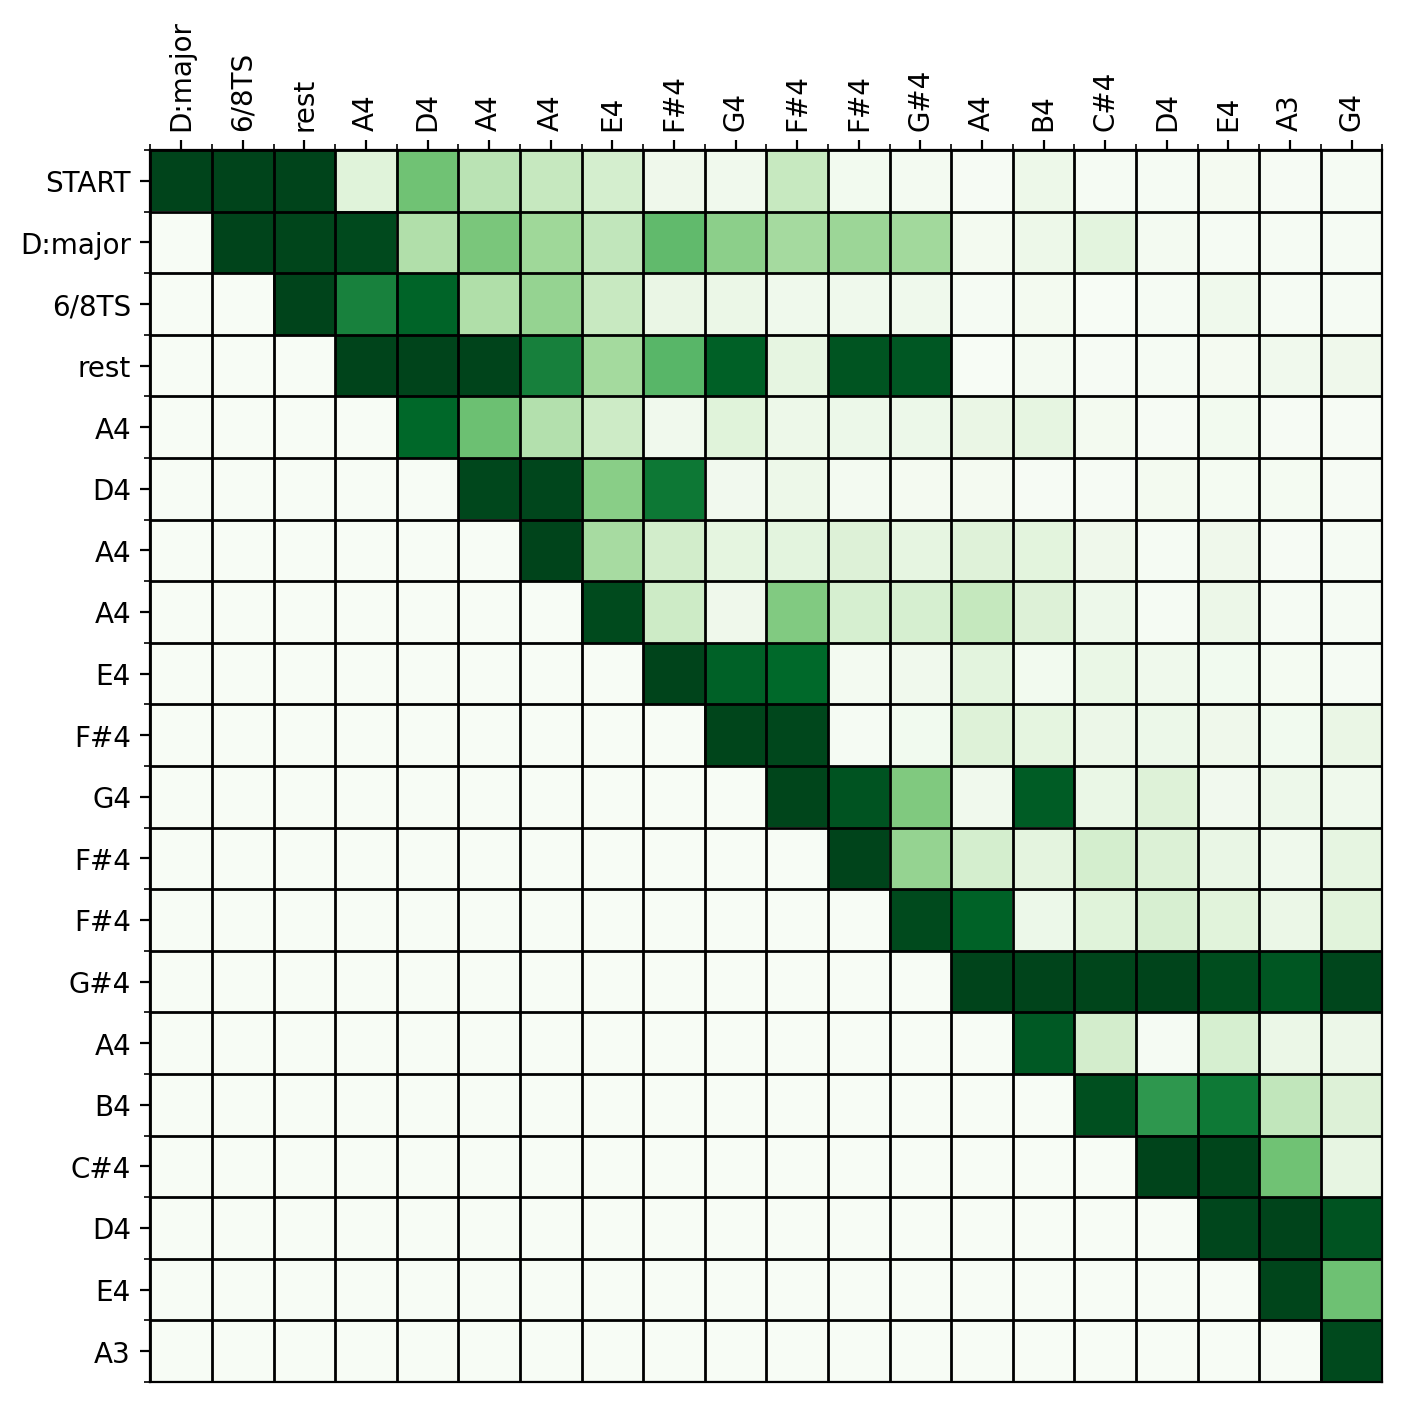

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()

In [ ]:
from google.colab import files
import shutil

shutil.make_archive("/content/model", 'zip', "my_folder")
shutil.make_archive("/content/output", 'zip', "my_folder")
shutil.make_archive("/content/transformer_output", 'zip', "my_folder")
shutil.make_archive("/content/data", 'zip', "my_folder")

'/content/data.zip'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Saving the model and its data on the Google drive

!cp -r /content/data /content/drive/MyDrive/GenAI
!cp -r /content/model /content/drive/MyDrive/GenAI
!cp -r /content/output /content/drive/MyDrive/GenAI
!cp -r /content/transformer_output /content/drive/MyDrive/GenAI